In [1]:
!pip install gpflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.9/392.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 4.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import cvxpy as cp
from scipy.linalg import solve_discrete_are, solve_continuous_are, sqrtm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from scipy.linalg import expm, solve_discrete_are
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from gpflow.inducing_variables import InducingPoints
import random
from sklearn.cluster import KMeans


# Example: fix the random seed for reproducibility
random.seed(26)
np.random.seed(26)
tf.random.set_seed(26)

# ---------------------------
# 1) System Parameters and True Dynamics
# ---------------------------
alpha = 2.0    # damping coefficient
beta = 1.0     # nonlinear acceleration coefficient
Ts = 0.1       # sampling time (seconds)

In [3]:
def car_dynamics_2d(xu, f):
    """
    True (unknown) dynamics:
      x_{k+1} = x_k + Ts * u_k
      u_{k+1} = u_k + Ts * (-alpha*u_k + beta*(u_k**2) + f)
    """
    x, u = xu
    x_next = x + Ts * u
    u_next = u + Ts * (-alpha*u + beta*u**2 + f)
    return np.array([x_next, u_next])

# ---------------------------
# 2) Local Linearization
# ---------------------------
def linearize_car_dynamics(x0u0, f0):
    """
    Linearize around (x0, u0, f0). Returns:
      A: 2x2 matrix = dX_{k+1}/dX_k
      B: 2x1 matrix = dX_{k+1}/df
      X0_next: Nominal next state computed with the true dynamics.
    """
    x0, u0 = x0u0
    dg1_dx = 0.0
    dg1_du = 1.0
    dg2_dx = 0.0
    dg2_du = -alpha + 2.0*beta*u0
    G = np.array([[dg1_dx, dg1_du],
                  [dg2_dx, dg2_du]])
    A = np.eye(2) + Ts * G
    B = Ts * np.array([[0.0],[1.0]])
    X0_next = car_dynamics_2d(np.array([x0, u0]), f0)
    return A, B, X0_next

# ---------------------------
# 3) Nominal Model Prediction
# ---------------------------
def linear_model_predict(xu, f, x0u0, f0, X0_next, A, B):
    """
    Compute the linearized (nominal) prediction:
      x_next = X0_next + A*(x - x0u0) + B*(f - f0)
    (xu is a (2,) vector and f is a scalar.)
    """
    diff = xu - x0u0
    diff_control = f - f0
    return  (A @ diff + B.flatten() * diff_control)

def lqr_tracking_controller(x, x_ref, K, u_ff=0.0):
    """
    Computes the control input using an LQR controller for tracking.

    Parameters:
      x: Current state vector.
      x_ref: Desired reference state.
      K: LQR gain matrix.
      u_ff: (Optional) Feedforward term (default 0).

    Returns:
      u: Control input.
    """
    e = x - x_ref  # tracking error
    u = -K @ e + u_ff
    return u

In [4]:
K_value = np.array([0.31346784, 0.17214169])
state_max = np.array([0, 0])
f0 = 0
P_d = np.array([[0.69294109, 0.31617568],
       [0.31617568, 0.18078269]])
# Ad = np.array([[1.        , 0.09063462],
#        [0.        , 0.81873075]])
# Bd = np.array([[0.00468116],
#        [0.09063767]])
Ac = np.array([[0        , 1],
       [0.        , -2]])
Bc = np.array([[0],
       [1]])

Ad = np.array([[1.        , Ts],
       [0.        , 1-Ts*alpha]])
Bd = np.array([[0],
       [Ts]])
x0u0 = state_max
#x_current = np.array([-1,2.1])
x_current = np.array([-2,2.5])

In [5]:
Ac = np.array([[0        , 1],
       [0.        , -2]])
Bc = np.array([[0],
       [1]])

# Design a discrete-time LQR controller (for example):
R_lqr = 1e-2
Q = 0.01 * np.eye(2)
P_c = solve_continuous_are(Ac, Bc, Q, R_lqr)
K_c = (1/R_lqr) * Bc.T @ P_c

In [6]:
# Design a discrete-time LQR controller (for example):
R_lqr = 1e-2
Q = 0.01 * np.eye(2)
P_d = solve_discrete_are(Ad, Bd, Q, R_lqr)
K_d = np.linalg.inv(Bd.T @ P_d @ Bd + R_lqr) @ (Bd.T @ P_d @ Ad)
K_value = K_d

In [7]:
def optimize_control_continuous(x, u_lin, gp, P, A, B, scaler_X):
    """
    Solve for u by minimizing (u - u_lin)^2 subject to:

      x^T (A^T P + P A)x + 2 x^T P B u <= 0

    This constraint corresponds to ensuring that the derivative of the
    Lyapunov function V(x)=x^T P x is non-positive, which is a typical
    condition for continuous-time stability.

    Parameters:
      x    : current state (numpy array, shape (n,))
      u_lin: nominal control (scalar)
      P    : Lyapunov matrix (numpy array, shape (n,n))
      A, B : linear model matrices (B should be a column vector)

    Returns:
      u_opt: optimized control (float)
    """



    pred_sigma = beta * (x[1]**2)
    pred_mean = 0*np.array([0.01,0.01])
    # print("mu = ", pred_mean, "sigma = ", pred_sigma)

    mu = np.array([0.2,0.1])
    sigma = 1e-3
    gamma = 1
    lambda_hamid = 1e-3

    #------------------------
    # Test Using GP
    #------------------------
    # pred_sigma = gp_sigma
    # pred_mean = np.array([0,gp_residual])

    # Define control as a scalar optimization variable
    u = cp.Variable()
    s = cp.Variable(nonneg=True)

    # Define the Lyapunov derivative condition V_dot(x)
    # Note: x, P, A, and B are constants here, so the term x.T @ (A.T@P+P@A) @ x is a scalar.
    V_dot = (x.T @ (A.T @ P + P @ A) @ x + 2 * (x.T @ P @ B) * u + 2 * (x.T @ P) @  pred_mean + 2*gamma*np.sqrt((x.T@P).T @ (x.T@P)) * pred_sigma)

    # Set the constraint so that V_dot <= 0
    constraint = [V_dot + lambda_hamid * x.T @ (P) @ x <= s]
    #constraint.append(s >= 1e-9 )
    constraint.append(u >= -5 )
    constraint.append(u <= 5 )

    # Objective: keep the control close to the nominal value u_lin
    objective = cp.Minimize(cp.square(u - u_lin) + s * 1e6)

    # Solve the optimization problem
    prob = cp.Problem(objective, constraint)
    prob.solve(solver=cp.SCS)
    prob.solve
    #print(2*gamma*np.sqrt((x.T@P_c).T @ (x.T@P_c)) * pred_sigma)

    return u.value, s.value

In [30]:
# ---------------------------
# 8) Tracking Controller
# ---------------------------
def simulate_to_target_continuous(x_current, target, K_value, A, B, f0, P, gp, x0u0, scaler_X, steps=50):
    """
    Simulate the true dynamics using a simple tracking controller:
      u = K_tracking*(target - x)
    Here K_tracking is fixed (e.g., [0.5, 0.5]). u is a scalar.
    Returns the final state and applied control.
    """
    x = x_current.copy()
    x_t = x_current.copy()
    X0_next = x
    traj_lin = []
    traj_true = []
    u_lqr = []
    u_opt = []
    s_s = []
    traj_lin.append(x)
    traj_true.append(x_t)


    for _ in range(steps):
        #print("x_lin",x,"x_nonlin",x_t)
        #u = -float(K_value @ (target - x))
        u_lqr_true = lqr_tracking_controller(x_t, target, K_value, 0)
        u_lin = lqr_tracking_controller(x, target, K_value, 0)
        #print("x=",x,"\n","u=",u,"\n","K=",K_value)
        #X0_next = car_dynamics_2d(x, u)
        u_lqr.append(u_lin)
        x = linear_model_predict(x, u_lin, x0u0, f0, X0_next, A, B)

        Ac = np.array([[0        , 1],
              [0.        , -2]])
        Bc = np.array([[0],
              [1]])

        # HAMID TEST
        #u,s = optimize_control_continuous(x_t, u_lqr_true, gp, P, Ac, Bc, scaler_X)
        s = 1
        s_s.append(s)
        #u = lqr_tracking_controller(x_t, target, K_value, 0)

        u = np.array(u_lqr_true)[0]
        u_opt.append(u)
        #print("u_lin",u_lin,"u_nonlin",u)

        x_t = car_dynamics_2d(x_t,u)
        # HAMID TEST
        #x_t = linear_model_predict(x_t, u, x0u0, f0, X0_next, A, B)

        #x = car_dynamics_2d(x,  u)
        traj_lin.append(x)
        traj_true.append(x_t)
        new_residual = car_dynamics_2d(x,  u) - linear_model_predict(x, u, x0u0, f0, X0_next, A, B)

    return x_t, u, u_lqr, u_opt, traj_lin, traj_true, s_s

In [9]:
x_current = np.array([-1,1.9])
x_measured, u_applied, u_LQR, u_OPT, traj_lin, traj_true, s_temp = simulate_to_target_continuous(x_current, state_max, K_c, Ad, Bd, f0, P_c, 1, x0u0, 1, steps=300)

x_lin [-1.   1.9] x_nonlin [-1.   1.9]
u_lin [-0.22692749] u_nonlin -0.22692749102272747
x_lin [-0.81        1.49730725] x_nonlin [-0.81        1.85830725]
u_lin [-0.15688812] u_nonlin -0.39000434362804803
x_lin [-0.66026927  1.18215699] x_nonlin [-0.62416927  1.79297595]
u_lin [-0.10311015] u_nonlin -0.5336472956576186
x_lin [-0.54205358  0.93541458] x_nonlin [-0.44487168  1.70249231]
u_lin [-0.06199161] u_nonlin -0.6545149590657893
x_lin [-0.44851212  0.7421325 ] x_nonlin [-0.27462245  1.58639035]
u_lin [-0.03072092] u_nonlin -0.749791202085839
x_lin [-0.37429887  0.59063391] x_nonlin [-0.11598341  1.4457966 ]
u_lin [-0.00710375] u_nonlin -0.8176416356576931
x_lin [-0.31523548  0.47179675] x_nonlin [0.02859625 1.2839059 ]
u_lin [0.01057211] u_nonlin -0.857680162003027
x_lin [-0.2680558   0.37849461] x_nonlin [0.15698684 1.10619814]
u_lin [0.02364241] u_nonlin -0.8713157323765558
x_lin [-0.23020634  0.30515993] x_nonlin [0.26760665 0.92019437]
u_lin [0.03314892] u_nonlin -0.8618233683

In [12]:
# N = 10000 # Number of points
# x_values = np.random.uniform(-10, 10, N)  # 100 random x values in [-10, 10]
# u_values = np.random.uniform(-10, 10, N)  # 100 random u values in [-10, 10]


# # Combine them in a list (or however you need)
# x_current = np.array([x_values, u_values])
# s = []
# j = []
# for i in range(N):
#     if ((x_current[:,i]).T@P_c@x_current[:,i] <= 1):
#         j.append(i)
#         #print((x_current[:,i]).T@P_c@x_current[:,i])
#         x_new, u_applied, u_LQR, u_OPT, traj_lin, traj_true, s_temp = simulate_to_target_continuous(np.array([x_values[i], u_values[i]]), state_max, K_c, Ad, Bd, f0, P_c, 1, x0u0, 1, steps=1)
#         #print("s_temp",s_temp)
#         s.append(s_temp)
#         #print("s",s)
#     else:
#         continue
# x_new = x_values[j]
# u_new = u_values[j]

# # Convert s_values to a NumPy array
# s_values = np.array(s)

# # Get the indices for which s < 0.000001
# valid_indices = np.where(s_values < 0.000001)[0]


# # (Optional) Plot current PCIS and target.
# eigvals, eigvecs = np.linalg.eig(P_c)
# a = 1/np.sqrt(eigvals[0])
# b = 1/np.sqrt(eigvals[1])
# theta = np.linspace(0, 2*np.pi, 200)
# ellipse_boundary = np.array([a*np.cos(theta), b*np.sin(theta)])
# ellipse_rotated = eigvecs @ ellipse_boundary
# # Plot only the points with s < 0.00001
# plt.figure()
# plt.scatter(x_new[valid_indices], u_new[valid_indices], color='red', label='s < 0.000001')
# plt.plot(ellipse_rotated[0,:], ellipse_rotated[1,:], 'b-', lw=2, label='CIS Riccati')
# plt.xlabel('x')
# plt.ylabel('u')
# plt.title('HS SET')
# plt.legend()
# plt.grid(True)
# plt.show()
# x_new = x_new[valid_indices]
# u_new = u_new[valid_indices]

In [13]:
#x_current = np.array([x_new[np.argmax(u_new)], u_new[np.argmax(u_new)]])
#x_measured, u_applied, u_LQR, u_OPT, traj_lin, traj_true, s_temp = simulate_to_target_continuous(x_current, state_max, K_c, Ad, Bd, f0, P_c, 1, x0u0, 1, steps=300)

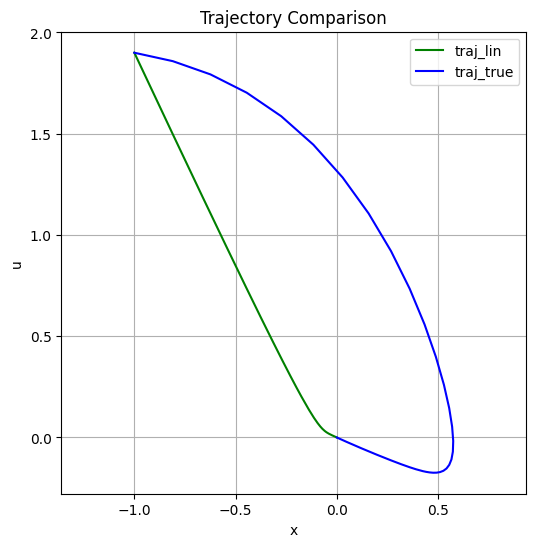

In [14]:
traj_lin = np.array(traj_lin)
traj_true = np.array(traj_true)

# (Optional) Plot current PCIS and target.
eigvals, eigvecs = np.linalg.eig(P_c)
a = 1/np.sqrt(eigvals[0])
b = 1/np.sqrt(eigvals[1])
theta = np.linspace(0, 2*np.pi, 200)
ellipse_boundary = np.array([a*np.cos(theta), b*np.sin(theta)])
ellipse_rotated = eigvecs @ ellipse_boundary
plt.figure(figsize=(6,6))
#plt.plot(ellipse_rotated[0,:], ellipse_rotated[1,:], 'b-', lw=2, label='CIS Riccati')
#plt.plot(ellipse_rotated_P[0,:], ellipse_rotated_P[1,:], 'r-', lw=2, label='PCIS')
plt.plot(traj_lin[:,0], traj_lin[:,1], 'g', label='traj_lin')
plt.plot(traj_true[:,0], traj_true[:,1], 'b', label='traj_true')
#plt.plot(state_max[0], state_max[1], 'co', label='Final Positon')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Trajectory Comparison')
plt.legend(loc="upper right")
plt.grid(True)
plt.axis('equal')
plt.show()

In [10]:
def optimize_control_continuous_gp(x, u_lin, gp, P, A, B, scaler_X):
    gp_input = x.reshape(1, -1)
    # Option 2 (if including control):
    # gp_input = np.hstack([x_gp, np.array([u_opt_val])]).reshape(1, -1)
    gp_mean, gp_sigma = gp.predict_f(gp_input)  # returns a TensorFlow tensor
    # Convert GP mean to a scalar residual:
    gp_residual = gp_mean.numpy().ravel()[0]
    gp_sigma =  gp_sigma.numpy().ravel()[0]


    gamma = 100
    lambda_hamid = 1e-3

    #------------------------
    # Test Using GP
    #------------------------
    pred_sigma = gp_sigma
    pred_mean = np.array([0,gp_residual])

    # Define control as a scalar optimization variable
    u = cp.Variable()
    s = cp.Variable(nonneg=True)

    # Define the Lyapunov derivative condition V_dot(x)
    # Note: x, P, A, and B are constants here, so the term x.T @ (A.T@P+P@A) @ x is a scalar.
    V_dot = (x.T @ (A.T @ P + P @ A) @ x + 2 * (x.T @ P @ B) * u + 2 * (x.T @ P) @  pred_mean + 2*gamma*np.sqrt((x.T@P).T @ (x.T@P)) * pred_sigma)

    # Set the constraint so that V_dot <= 0
    constraint = [V_dot + lambda_hamid * x.T @ (P) @ x <= s]
    #constraint.append(s >= 1e-9 )
    constraint.append(u >= -5 )
    constraint.append(u <= 5 )

    # Objective: keep the control close to the nominal value u_lin
    objective = cp.Minimize(cp.square(u - u_lin) + s * 1e6)

    # Solve the optimization problem
    prob = cp.Problem(objective, constraint)
    prob.solve(solver=cp.SCS)
    prob.solve

    return u.value, s.value

In [11]:
# ---------------------------
# 8) Tracking Controller with GP-based prediction
# ---------------------------
def simulate_to_target_continuous_gp(x_current, target, K_value, A, B, f0, P, gp,
                                  x0u0, scaler_X, steps=50):
    """
    Simulate the dynamics using a tracking controller.
    Three trajectories are computed:
      - traj_lin: evolution using the linear (nominal) model.
      - traj_true: evolution using the true nonlinear dynamics.
      - traj_gp: evolution using the GP-corrected model:
                linear model + GP-predicted residual.
    The controller uses a combination of LQR and an optimization (via the GP)
    to compute the applied control.

    Inputs:
      x_current  : initial state
      target     : target state
      K_value    : tracking gain (for LQR controller)
      A, B, f0   : parameters for the linear model
      P          : matrix used in the CLF (e.g., for V(x)= x^T P x)
      gp         : trained GP model (e.g., a GPflow model) that predicts the residual.
      x0u0       : other parameters needed by linear_model_predict
      scaler_X   : a scaler (if any) used to scale inputs for the GP (optional)
      steps      : number of simulation steps

    Returns:
      x_t         : final state from true dynamics
      u           : final applied control
      u_lqr       : list of LQR control actions (nominal from linear model)
      u_opt       : list of optimized control actions (via GP-based optimization)
      traj_lin    : trajectory from the linear model prediction
      traj_true   : trajectory from the true dynamics
      traj_gp     : trajectory from the GP-corrected model
      s_s         : list of slack variables from the optimization
    """
    # Initialize states:
    x = x_current.copy()        # state for linear model prediction
    x_t = x_current.copy()      # state for true dynamics
    x_gp = x_current.copy()     # state for GP-corrected model

    X0_next = x.copy()

    # Initialize trajectories:
    traj_lin = [x.copy()]
    traj_true = [x_t.copy()]
    traj_gp = [x_gp.copy()]
    u_lqr = []
    u_opt = []
    s_s = []

    for _ in range(steps):
        #print("x_lin:", x, "x_true:", x_t, "x_gp:", x_gp)

        # Compute nominal control from a tracking LQR controller.
        # Here, we assume lqr_tracking_controller returns a scalar control.
        u_lqr_true = lqr_tracking_controller(x_t, target, K_value, 0)
        u_lin = lqr_tracking_controller(x, target, K_value, 0)
        u_gp = lqr_tracking_controller(x_gp, target, K_value, 0)
        u_lqr.append(u_lin)

        # Update the linear model state:
        x = linear_model_predict(x, u_lin, x0u0, f0, X0_next, A, B)

        # Define continuous-time matrices for the optimization (if needed).
        Ac = np.array([[0, 1],
                       [0, -2]])
        Bc = np.array([[0],
                       [1]])

        # Use your GP-based optimization function to get the control
        # that takes into account the GP-predicted residual.
        # This function should return an optimized control u and slack s.
        #u_opt_val, s_val = optimize_control_continuous_gp(x_t, u_lqr_true, gp, P, Ac, Bc, scaler_X)
        u_opt_val, s_val = optimize_control_continuous_gp_closed_form(x_t, u_lqr_true, gp, P, Ac, Bc, scaler_X)

        s_s.append(s_val)
        u_opt.append(u_opt_val)
        #print("u_lin:", u_lin, "u_opt:", u_opt_val)

        # Update the true dynamics state (nonlinear simulation).
        x_t = car_dynamics_2d(x_t, u_opt_val)

        # Update the GP-based model state.
        # The GP is trained on the residual: true dynamics - linear model.
        # Form the input for the GP. Here we assume the GP was trained on the state.
        # If your GP was trained on state AND control, concatenate accordingly.
        # Option 1: Using just state:
        gp_input = x.reshape(1, -1)
        # Option 2 (if including control):
        # gp_input = np.hstack([x_gp, np.array([u_opt_val])]).reshape(1, -1)
        gp_mean, _ = gp.predict_f(gp_input)  # returns a TensorFlow tensor
        # Convert GP mean to a scalar residual:
        gp_residual = gp_mean.numpy().ravel()[0]
        # Update the GP-corrected state: add the GP-predicted residual to the linear model prediction.

        #u_opt_val_gp, s_temp_gp = optimize_control_continuous(x_gp, u_lqr_true, gp, P, Ac, Bc, scaler_X)
        #x_gp = x # linear_model_predict(x, u_lin, x0u0, f0, X0_next, A, B)
        x_gp[0] = x[0]
        x_gp[1] = x[1] + gp_residual
        #print("X_lin",x,"X_gp",x_gp)
        #print("True Residuals:", x_t[1]-x[1], "Estimated GP Residuals:",  gp_residual)

        #print("gp_input:",gp_input,"--- gp_residual:",gp_residual, "--- x_gp_next:",x_gp[1],"gp_output:",x_gp)
        traj_gp.append(x_gp.copy())

        # Save trajectories:
        traj_lin.append(x.copy())
        traj_true.append(x_t.copy())

        # Optionally compute new residual for logging:
        new_residual = car_dynamics_2d(x, u_opt_val) - linear_model_predict(x, u_opt_val, x0u0, f0, X0_next, A, B)
        # You can log new_residual if desired.
        #print("gamma",gamma)
    return x_t, u_opt_val, u_lqr, u_opt, traj_lin, traj_true, traj_gp, s_s

In [12]:
def optimize_control_continuous_gp_closed_form(x, u_lin, gp, P, A, B, scaler_X):
    """
    Closed-form solver for the single-scalar control problem:

      minimize (u - u_lin)^2 + 1e6 * s
      subject to:
         s >= 0
         x^T(A^T P + P A)x + 2(x^T P B)u + 2(x^T P).pred_mean
             + 2 gamma ||x^T P|| pred_sigma + lambda * x^T P x  <=  s
         -5 <= u <= 5

    Returns:
      (u_star, s_star)
    """
    # 1) Evaluate the GP at state x
    #    If needed, scale x before predict_f, e.g.:
    #    x_scaled = scaler_X.transform(x.reshape(1,-1)) if scaler_X is not None else x.reshape(1, -1)
    x_reshaped = x.reshape(1, -1)
    gp_mean_tf, gp_sigma_tf = gp.predict_f(x_reshaped)
    gp_residual = gp_mean_tf.numpy().ravel()[0]
    gp_sigma = gp_sigma_tf.numpy().ravel()[0]

    gamma = 300.0
    lambda_hamid = 1e-3
    BIG_PENALTY = 1e6

    # Build constants in the constraint
    pred_mean = np.array([0.0, gp_residual])
    pred_sigma = gp_sigma
    # The "V_dot" expression is:
    #   C0 + d*u, plus alpha
    # where:
    #   C0 = x^T(A^T P + P A)x + 2(x^T P).pred_mean + 2 gamma||x^T P|| pred_sigma
    #   d  = 2(x^T P B)
    #   alpha = lambda_hamid * x^T P x

    # C0
    C0 = x @ (A.T @ P + P @ A) @ x
    gp_offset = 2 * (x @ P) @ pred_mean
    sigma_offset = 2 * gamma * np.linalg.norm(x @ P) * pred_sigma
    C = C0 + gp_offset + sigma_offset

    d = 2.0 * (x @ P @ B)
    alpha = lambda_hamid * (x @ P @ x)

    # We'll define g(u) = C + d*u + alpha.
    # The constraint is s >= g(u) and s >= 0.
    # The objective is (u - u_lin)^2 + BIG_PENALTY * s.

    # ============== CASE A: s=0 feasible? ==============
    # If we can find u in [-5,5] with g(u) <= 0, pick the one closest to u_lin.
    u_feasible = _check_zero_slack_feasible(C, d, alpha, u_lin)
    if u_feasible is not None:
        return u_feasible, 0.0

    # ============== CASE B: s>0 forced ==============
    # Then cost = (u - u_lin)^2 + BIG_PENALTY*(C + d*u + alpha), with C + d*u + alpha >= 0.
    best_u, best_s = _solve_forced_slack(C, d, alpha, u_lin, BIG_PENALTY)
    return best_u, best_s


def _check_zero_slack_feasible(C, d, alpha, u_lin):
    """
    If there's a u in [-5,5] s.t. C + d*u + alpha <= 0,
    pick the one that is as close as possible to u_lin.
    Return that u, or None if not feasible.
    """
    # We want g(u) = C + d*u + alpha <= 0
    # => d*u <= - (C + alpha).
    denom = d
    numer = -(C + alpha)
    if abs(denom) < 1e-14:
        # If d ~ 0, then g(u)=C+alpha independent of u.
        if C + alpha <= 0:
            # Then any u in [-5,5] works.
            return float(np.clip(u_lin, -5, 5))
        else:
            return None
    else:
        # d != 0 => solve inequality
        threshold = numer / denom  # the boundary
        if d > 0:
            # u <= threshold
            low, high = -5.0, min(5.0, threshold)
            if low <= high:
                # clamp u_lin to [low, high]
                return float(np.clip(u_lin, low, high))
            else:
                return None
        else:
            # d < 0 => u >= threshold
            low, high = max(-5.0, threshold), 5.0
            if low <= high:
                return float(np.clip(u_lin, low, high))
            else:
                return None


def _solve_forced_slack(C, d, alpha, u_lin, BIG_PENALTY):
    """
    Solve the forced slack case: cost(u) = (u - u_lin)^2 + BIG_PENALTY * (C + d*u + alpha),
    s.t. -5 <= u <= 5, and C + d*u + alpha >= 0.
    We'll do derivative=0 + boundary check.
    """
    import math

    def cost(u):
        return (u - u_lin)**2 + BIG_PENALTY*(C + d*u + alpha)

    # derivative wrt u: 2(u - u_lin) + BIG_PENALTY*d
    u_star = u_lin - 0.5 * BIG_PENALTY * d

    # clamp to [-5,5], but must also satisfy g(u_star)>=0 => C + d*u_star + alpha >=0
    feasible_candidates = []

    def feasible(u):
        return (C + d*u + alpha) >= -1e-12  # small tolerance

    # candidate #1: the unconstrained optimum clamped
    u_clamped = max(-5.0, min(5.0, u_star))
    if feasible(u_clamped):
        feasible_candidates.append(u_clamped)

    # candidate #2: boundary -5
    if feasible(-5):
        feasible_candidates.append(-5.0)

    # candidate #3: boundary 5
    if feasible(5):
        feasible_candidates.append(5.0)

    # If no feasible candidate found, we still pick the boundary with minimal g(u),
    # but that typically means no real solution for the constraint. We'll do a fallback:
    if not feasible_candidates:
        # fallback => pick among [-5,5] whichever yields smaller cost
        c_minus5 = cost(-5.0)
        c_plus5 = cost(5.0)
        if c_minus5 < c_plus5:
            return -5.0, max(0.0, C + d*(-5) + alpha)
        else:
            return 5.0, max(0.0, C + d*(5) + alpha)

    # Among feasible candidates, pick minimal cost
    best_u = None
    best_val = math.inf
    for u_cand in feasible_candidates:
        val = cost(u_cand)
        if val < best_val:
            best_val = val
            best_u = u_cand

    best_s = max(0.0, C + d*best_u + alpha)
    return float(best_u), float(best_s)


In [13]:
# ---------------------------
# 8) Tracking Controller with GP-based prediction
# ---------------------------
def lyapunov_hs(x_current, target, K_value, A, B, f0, P, gp,
                                  x0u0, scaler_X, steps=50):
    """
    Simulate the dynamics using a tracking controller.
    Three trajectories are computed:
      - traj_lin: evolution using the linear (nominal) model.
      - traj_true: evolution using the true nonlinear dynamics.
      - traj_gp: evolution using the GP-corrected model:
                linear model + GP-predicted residual.
    The controller uses a combination of LQR and an optimization (via the GP)
    to compute the applied control.

    Inputs:
      x_current  : initial state
      target     : target state
      K_value    : tracking gain (for LQR controller)
      A, B, f0   : parameters for the linear model
      P          : matrix used in the CLF (e.g., for V(x)= x^T P x)
      gp         : trained GP model (e.g., a GPflow model) that predicts the residual.
      x0u0       : other parameters needed by linear_model_predict
      scaler_X   : a scaler (if any) used to scale inputs for the GP (optional)
      steps      : number of simulation steps

    Returns:
      x_t         : final state from true dynamics
      u           : final applied control
      u_lqr       : list of LQR control actions (nominal from linear model)
      u_opt       : list of optimized control actions (via GP-based optimization)
      traj_lin    : trajectory from the linear model prediction
      traj_true   : trajectory from the true dynamics
      traj_gp     : trajectory from the GP-corrected model
      s_s         : list of slack variables from the optimization
    """
    # Initialize states:
    x = x_current.copy()        # state for linear model prediction
    x_t = x_current.copy()      # state for true dynamics
    x_gp = x_current.copy()     # state for GP-corrected model

    X0_next = x.copy()

    # Initialize trajectories:
    traj_lin = [x.copy()]
    traj_true = [x_t.copy()]
    traj_gp = [x_gp.copy()]
    u_lqr = []
    u_opt = []
    s_s = []

    for _ in range(steps):
        #print("x_lin:", x, "x_true:", x_t, "x_gp:", x_gp)

        # Compute nominal control from a tracking LQR controller.
        # Here, we assume lqr_tracking_controller returns a scalar control.
        u_lqr_true = lqr_tracking_controller(x_t, target, K_value, 0)
        u_lin = lqr_tracking_controller(x, target, K_value, 0)
        u_lqr.append(u_lin)

        # Define continuous-time matrices for the optimization (if needed).
        Ac = np.array([[0, 1],
                       [0, -2]])
        Bc = np.array([[0],
                       [1]])

        # Use your GP-based optimization function to get the control
        # that takes into account the GP-predicted residual.
        # This function should return an optimized control u and slack s.
        u_opt_val, s_val = optimize_control_continuous_gp_closed_form(x_t, u_lqr_true, gp, P, Ac, Bc, scaler_X)
        #u_opt_val, s_val = optimize_control_continuous_gp(x_t, u_lqr_true, gp, P, Ac, Bc, scaler_X)

        s_s.append(s_val)
        u_opt.append(u_opt_val)

        # You can log new_residual if desired.
        #print("gamma",gamma)
    return  u_opt_val, s_s

X_data shape = (300, 2)
Y_data shape = (300, 1)
Step 0, Loss=-372.546785
Step 200, Loss=-684.912238
Step 400, Loss=-974.798929
Step 600, Loss=-1243.575521
Step 800, Loss=-1445.055342
=== Initial GP Trained ===
Final training loss: -1562.156609
Kernel lengthscales: 0.30245212094591384
Kernel variance:      1.3339881643036477
Likelihood variance:  2.2976958889491906e-06


In [16]:
def label_gamma(model, X_data, Y_data, gamma):
    labels = []
    for i in range(len(X_data)):
        gp_input = X_data[i].reshape(1, -1)
        gp_mean, gp_sigma = model.predict_f(gp_input)
        # Convert GP mean to a scalar residual
        gp_residual = gp_mean.numpy().ravel()[0]
        gp_sigma_val = gp_sigma.numpy().ravel()[0]

        if abs(Y_data[i] - gp_residual) <= gamma * gp_sigma_val:
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [22]:
# # List of gamma values
# gammas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# # Compute and print Pr(gamma) for each gamma
# for gamma in gammas:
#     labels = label_gamma(model, X_data, Y_data, gamma)
#     Pr_gamma = sum(labels) / len(labels)
#     print(f"Gamma: {gamma}, Probability: {Pr_gamma:.6f}")

X_data shape = (300, 2)
Y_data shape = (300, 1)
Step 0, Loss=-372.546785
Step 200, Loss=-684.912238
Step 400, Loss=-974.798929
Step 600, Loss=-1243.575521
Step 800, Loss=-1445.055342
=== Initial GP Trained ===
Final training loss: -1562.156609
Kernel lengthscales: 0.30245212094591384
Kernel variance:      1.3339881643036477
Likelihood variance:  2.2976958889491906e-06
Number of points inside ellipse: 5776
Number of points passing threshold sigma <= 0.5 : 5


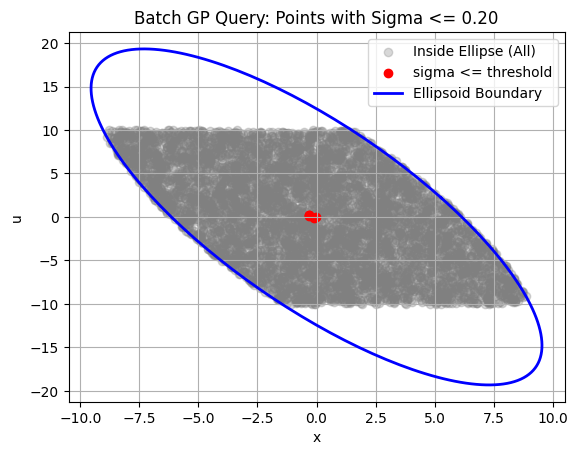

In [36]:
x_current = np.array([-1,1.9])
x_measured, u_applied, u_LQR, u_OPT, traj_lin, traj_true, s_temp = simulate_to_target_continuous(x_current, state_max, K_c, Ad, Bd, f0, P_c, 1, x0u0, 1, steps=300)
###############################################################################
# 1. Gather Data
###############################################################################
# Suppose you have a rollout: (traj_lin, traj_true)
# We'll define X_data (states) and Y_data (residuals = true - linear).
N = len(traj_lin) - 1
D = 2  # dimension of state

X_data = np.array(traj_lin)[:-1]    # shape (N,2)
Y_temp = (np.array(traj_true) - np.array(traj_lin))[1:, 1]  # shape (N,)
Y_data = Y_temp[:, None]           # shape (N,1)

print("X_data shape =", X_data.shape)
print("Y_data shape =", Y_data.shape)

# 1. Choose the number of inducing points
M = 30

# 2. (Optional) Use k-means to initialize inducing points
kmeans = KMeans(n_clusters=M, random_state=42)
kmeans.fit(X_data)
Z_init = kmeans.cluster_centers_  # shape (M, D)

# 3. Define the kernel
kernel = gpflow.kernels.SquaredExponential()

# 4. Build the SGPR model
model = gpflow.models.SGPR(
    data=(X_data, Y_data),
    kernel=kernel,
    inducing_variable=InducingPoints(Z_init),
)

# (Optional) Make the likelihood variance trainable and give it an initial guess:
model.likelihood.variance.assign(0.01)
model.likelihood.variance.trainable = True

# 5. Create an Adam optimizer and define a training step
opt = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        loss = model.training_loss()
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# 6. Run a certain number of training steps
num_steps = 1000
for step in range(num_steps):
    current_loss = optimization_step()
    if step % 200 == 0:
        print(f"Step {step}, Loss={current_loss.numpy():.6f}")

# 7. Check the final loss and kernel hyperparameters
final_loss = model.training_loss().numpy()
print("=== Initial GP Trained ===")
print(f"Final training loss: {final_loss:.6f}")

if hasattr(model.kernel, "lengthscales"):
    print("Kernel lengthscales:", model.kernel.lengthscales.numpy())
if hasattr(model.kernel, "variance"):
    print("Kernel variance:     ", model.kernel.variance.numpy())

# (Optional) Inspect the likelihood noise variance
print("Likelihood variance: ", model.likelihood.variance.numpy())

N = 10000 # Number of points
np.random.seed(26)
x_values = np.random.uniform(-10, 10, N)  # 100 random x values in [-10, 10]
u_values = np.random.uniform(-10, 10, N)  # 100 random u values in [-10, 10]

# Combine them in a list (or however you need)
x_current = np.array([x_values, u_values])

threshold_mean = 0.5
threshold_sigma = 0.2

# Suppose x_current has shape (2, N).
#   x_current[0, i] = x-value
#   x_current[1, i] = u-value

# 1) Gather indices of points inside the ellipse x^T P_c x <= 1
inside_indices = []
for i in range(N):
    x_vec = x_current[:, i]  # shape (2,)
    if (x_vec.T @ P_c @ x_vec) <= 1:
        inside_indices.append(i)

inside_indices = np.array(inside_indices, dtype=int)

# 2) Extract all those points as a (k, 2) array for GPflow
X_inside = x_current[:, inside_indices].T  # shape: (k, 2), where k <= N

# 3) Call the GP ONCE for all points
gp_mean_tf, gp_sigma_tf = model.predict_f(X_inside)
gp_mean = gp_mean_tf.numpy().ravel()   # shape (k,)
gp_sigma = gp_sigma_tf.numpy().ravel() # shape (k,)

# 4) Based on sigma <= threshold, define s-values
#    We'll say s=0 if sigma <= threshold, else s=1 (like your example).
#    This is a vectorized comparison:
s_values_mean = np.where(gp_mean <= threshold_mean, 0.0, 1.0)
s_values_sigma = np.where(gp_sigma <= threshold_sigma, 0.0, 1.0)

# 5) "valid_indices": those with s=0
valid_indices = np.where(
(s_values_mean == 0.0) & (s_values_sigma == 0.0)
)[0]

# 6) The final x_new, u_new are the "inside" points that also have s=0
x_new = X_inside[valid_indices, 0]  # shape (k_valid,)
u_new = X_inside[valid_indices, 1]  # shape (k_valid,)

print("Number of points inside ellipse:", len(inside_indices))
print("Number of points passing threshold sigma <=", threshold_mean, ":", len(valid_indices))

# 7) Plot the results
#    We'll also plot the ellipse boundary for reference
eigvals, eigvecs = np.linalg.eig(P_c)
a = 1/np.sqrt(eigvals[0])
b = 1/np.sqrt(eigvals[1])
theta = np.linspace(0, 2*np.pi, 200)
ellipse_boundary = np.array([a*np.cos(theta), b*np.sin(theta)])
ellipse_rotated = eigvecs @ ellipse_boundary

plt.figure()
# Plot all points inside the ellipse (optional):
all_x = X_inside[:, 0]
all_u = X_inside[:, 1]
plt.scatter(all_x, all_u, color='gray', alpha=0.3, label='Inside Ellipse (All)')

# Plot the final "valid" set in red
plt.scatter(x_new, u_new, color='red', label='sigma <= threshold')

plt.plot(ellipse_rotated[0,:], ellipse_rotated[1,:], 'b-', lw=2, label='Ellipsoid Boundary')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Batch GP Query: Points with Sigma <= {:.2f}'.format(threshold_sigma))
plt.legend()
plt.grid(True)
plt.show()

In [19]:

# ------------------------------------------------------------------------
# 2) New "choose next" function, no dynamic radius
# ------------------------------------------------------------------------
def choose_next_ucb_below_full_ell(model, X_old,
                                  cands_full,
                                  beta=2.0,
                                  acq_threshold=0.5):
    """
    Always consider the fixed set cands_full (inside P_c-ellipse).
    Remove any already in X_old, then:
      - among those with mu+beta*sigma <= acq_threshold,
        pick the one with highest sigma.
      - if none, fall back to argmax(mu+beta*sigma).
    """
    # 1) Remove already seen points
    if X_old.shape[0] > 0:
        oldset = set(map(tuple, np.round(X_old,6)))
        cands = np.array([p for p in cands_full
                          if tuple(np.round(p,6)) not in oldset])
        if cands.size == 0:
            # nothing new to sample
            cands = cands_full.copy()
    else:
        cands = cands_full.copy()

In [70]:
# -----------------------------------------------------------------------------
# 3) Safe‑UCB acquisition: pick the next point
# -----------------------------------------------------------------------------
def choose_next_safe_ucb(model, X_old, cands_full, beta=2.0, epsilon: float = 0):
    """
    Safe‑UCB:
      S_k = { x in cands_full \ X_old : mu(x)+beta*sigma(x) <= 0 }
      pick x* = argmax_{x in S_k} sigma(x).
    If S_k empty, pick argmin_x [mu(x)+beta*sigma(x)] over cands_full \ X_old.
    """
    # 1) remove already sampled
    if X_old.shape[0]:
        seen = set(map(tuple, np.round(X_old,6)))
        cands = np.array([x for x in cands_full if tuple(np.round(x,6)) not in seen])
        if cands.size == 0:
            cands = cands_full.copy()
    else:
        cands = cands_full.copy()

    # 2) batch GP predict
    mu_tf, sigma_tf = model.predict_f(cands)
    mu = mu_tf.numpy().ravel()
    sigma = sigma_tf.numpy().ravel()

    # 3) UCB = mu + beta*sigma
    ucb = mu + beta * sigma
    print(mu)

    # 4) Safe set = ucb <= 0
    safe_idx = np.where(ucb <= epsilon)[0]
    if safe_idx.size:
        # choose point of max uncertainty
        idx = safe_idx[np.argmax(sigma[safe_idx])]
    else:
        # fallback to safest max (min UCB)
        idx = np.argmin(ucb)

    return tuple(cands[idx])


<ipython-input-3-8b9c8b2d033e>:9: RuntimeWarning: overflow encountered in scalar power
  u_next = u + Ts * (-alpha*u + beta*u**2 + f)
<ipython-input-3-8b9c8b2d033e>:9: RuntimeWarning: invalid value encountered in scalar add
  u_next = u + Ts * (-alpha*u + beta*u**2 + f)
<ipython-input-3-8b9c8b2d033e>:45: RuntimeWarning: invalid value encountered in multiply
  return  (A @ diff + B.flatten() * diff_control)
<ipython-input-30-d6c3ad0483d7>:55: RuntimeWarning: invalid value encountered in subtract
  new_residual = car_dynamics_2d(x,  u) - linear_model_predict(x, u, x0u0, f0, X0_next, A, B)
<ipython-input-3-8b9c8b2d033e>:9: RuntimeWarning: overflow encountered in scalar power
  u_next = u + Ts * (-alpha*u + beta*u**2 + f)
<ipython-input-3-8b9c8b2d033e>:9: RuntimeWarning: invalid value encountered in scalar add
  u_next = u + Ts * (-alpha*u + beta*u**2 + f)
<ipython-input-3-8b9c8b2d033e>:45: RuntimeWarning: invalid value encountered in multiply
  return  (A @ diff + B.flatten() * diff_contr

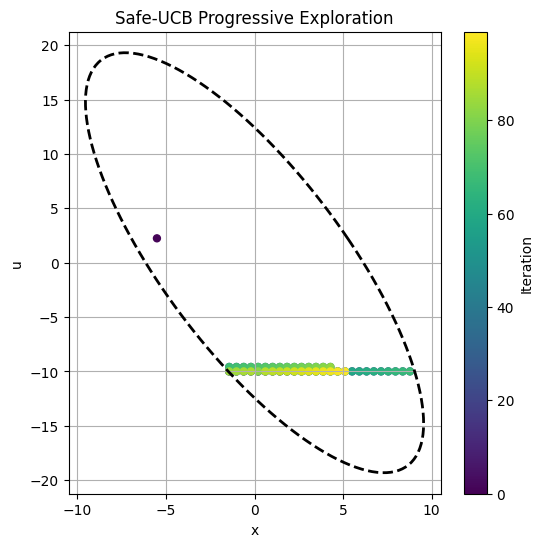

In [63]:
x_current = np.array([-1,1.9])
x_measured, u_applied, u_LQR, u_OPT, traj_lin, traj_true, s_temp = simulate_to_target_continuous(x_current, state_max, K_c, Ad, Bd, f0, P_c, 1, x0u0, 1, steps=300)
###############################################################################
# 1. Gather Data
###############################################################################
# Suppose you have a rollout: (traj_lin, traj_true)
# We'll define X_data (states) and Y_data (residuals = true - linear).
N = len(traj_lin) - 1
D = 2  # dimension of state

X_data = np.array(traj_lin)[:-1]    # shape (N,2)
Y_temp = (np.array(traj_true) - np.array(traj_lin))[1:, 1]  # shape (N,)
Y_data = Y_temp[:, None]           # shape (N,1)
# -----------------------------------------------------------------------------
# 1) Initial sparse GP training on (X_data, Y_data)
# -----------------------------------------------------------------------------
# X_data: (N0,2), Y_data: (N0,1)
M = 30
kmeans = KMeans(n_clusters=M, random_state=0).fit(X_data)
Z_init = kmeans.cluster_centers_

kernel = gpflow.kernels.SquaredExponential()
model = gpflow.models.SGPR(data=(X_data, Y_data),
                           kernel=kernel,
                           inducing_variable=InducingPoints(Z_init))
model.likelihood.variance.assign(1e-2)
model.likelihood.variance.trainable = True

opt = tf.optimizers.Adam(1e-2)
@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        loss = model.training_loss()
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

for _ in range(500):
    optimization_step()

X_old, Y_old = model.data

# -----------------------------------------------------------------------------
# 2) Precompute the fixed candidate grid inside x^T P_c x <= 1
# -----------------------------------------------------------------------------
xmin, xmax = -10, 10
umin, umax = -10, 10
grid_res = 50

xs = np.linspace(xmin, xmax, grid_res)
us = np.linspace(umin, umax, grid_res)
XX, UU = np.meshgrid(xs, us, indexing='xy')
all_cands = np.vstack([XX.ravel(), UU.ravel()]).T  # (2500,2)

ell_vals = np.einsum('ij,jk,ik->i', all_cands, P_c, all_cands)
cands_full = all_cands[ell_vals <= 1.0]            # inside the ellipse


# -----------------------------------------------------------------------------
# 4) Main exploration loop
# -----------------------------------------------------------------------------
iterations = 100
MAX_DATA = 2000
INDUCE_REFRESH = 20
GP_UPDATE_EVERY = 5
GP_UPDATE_STEPS = 100

x_safe, u_safe = [], []

for k in range(iterations):
    # pick next init via Safe‑UCB
    x_star, u_star = choose_next_safe_ucb(model, X_old, cands_full, beta=0)
    init = np.array([x_star, u_star])

    # simulate
    x_meas, u_app, u_lqr, u_opt, traj_lin, traj_true, s_temp = \
      simulate_to_target_continuous(
        init, state_max, K_c, Ad, Bd,
        f0, P_c, model, x0u0, 1, steps=50
      )

    traj_lin  = np.asarray(traj_lin)
    traj_true = np.asarray(traj_true)

    # gather new data
    X_new = traj_lin[:-1]                       # (steps,2)
    Y_new = (traj_true[1:] - traj_lin[1:])[:,1:2]  # (steps,1)

    # update GP dataset (rolling buffer)
    X_old = np.vstack([X_old, X_new])[-MAX_DATA:]
    Y_old = np.vstack([Y_old, Y_new])[-MAX_DATA:]
    model.data = (X_old, Y_old)

    # occasionally refresh inducing points
    if k % INDUCE_REFRESH == 0:
        Z = KMeans(n_clusters=M, random_state=0).fit(X_old).cluster_centers_
        model.inducing_variable = InducingPoints(Z)

    # retrain GP occasionally
    if k % GP_UPDATE_EVERY == 0:
        for _ in range(GP_UPDATE_STEPS):
            optimization_step()

    # record for final plot
    x_safe.append(x_star)
    u_safe.append(u_star)

# -----------------------------------------------------------------------------
# 5) Final plot
# -----------------------------------------------------------------------------
x_safe = np.array(x_safe)
u_safe = np.array(u_safe)

eigvals, eigvecs = np.linalg.eig(P_c)
a, b = 1/np.sqrt(eigvals[0]), 1/np.sqrt(eigvals[1])
theta = np.linspace(0,2*np.pi,300)
ell = np.vstack([a*np.cos(theta), b*np.sin(theta)])
ell = eigvecs @ ell

plt.figure(figsize=(6,6))
plt.scatter(x_safe, u_safe, c=np.arange(iterations), cmap='viridis', s=25)
plt.plot(ell[0], ell[1], 'k--', lw=2)
plt.xlabel('x'); plt.ylabel('u')
plt.title('Safe‑UCB Progressive Exploration')
plt.colorbar(label='Iteration')
plt.grid(True)
plt.show()


In [94]:
xmin, xmax = -10, 10
umin, umax = -10, 10
grid_res = 50

xs = np.linspace(xmin, xmax, grid_res)
us = np.linspace(umin, umax, grid_res)
XX, UU = np.meshgrid(xs, us, indexing='xy')
all_cands = np.vstack([XX.ravel(), UU.ravel()]).T  # (2500,2)

ell_vals = np.einsum('ij,jk,ik->i', all_cands, P_c, all_cands)
cands_full = all_cands[ell_vals <= 1.0]            # inside the ellipse
cands_full

In [91]:
len(cands_full)
cands = cands_full[:-10]
len(cands)
cands

array([[ -1.42857143, -10.        ],
       [ -1.02040816, -10.        ],
       [ -0.6122449 , -10.        ],
       ...,
       [ -3.46938776,  10.        ],
       [ -3.06122449,  10.        ],
       [ -2.65306122,  10.        ]])

In [89]:
print("ℓ:", model.kernel.lengthscales.numpy())
print("σ²:", model.kernel.variance.numpy())
print("noise:", model.likelihood.variance.numpy())
model.kernel.lengthscales.assign(1.0)
model.kernel.variance.assign(1.0)
model.likelihood.variance.assign(1e-2)
# and retrain for a few steps
for _ in range(100): optimization_step()


ℓ: 0.3195305708600124
σ²: 2.0879871070041425
noise: 1.063122451328376e-06


In [90]:
# 2) batch GP predict
mu_tf, sigma_tf = model.predict_f(cands)
mu = mu_tf.numpy().ravel()
sigma = sigma_tf.numpy().ravel()
mu, sigma

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([1.74226748, 1.38875641, 0.75587909, 0.18361963, 0.18364152,
        0.7555779 , 1.38461857, 1.71103753, 1.7031782 , 1.35726217]))

In [71]:
x_star, u_star = choose_next_safe_ucb(model, X_old, cands_full, beta=0)
init = np.array([x_star, u_star])
init

[nan nan nan ... nan nan nan]


array([  5.51020408, -10.        ])

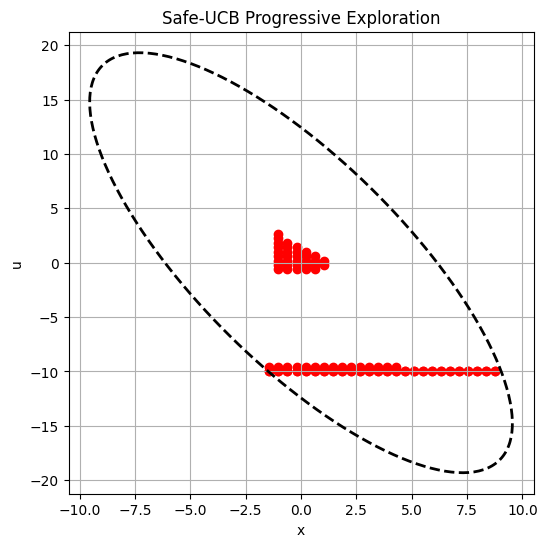

In [61]:

eigvals, eigvecs = np.linalg.eig(P_c)
a, b = 1/np.sqrt(eigvals[0]), 1/np.sqrt(eigvals[1])
theta = np.linspace(0,2*np.pi,300)
ell = np.vstack([a*np.cos(theta), b*np.sin(theta)])
ell = eigvecs @ ell

plt.figure(figsize=(6,6))
plt.scatter(x_safe, u_safe,color="red")
plt.plot(ell[0], ell[1], 'k--', lw=2)
plt.xlabel('x'); plt.ylabel('u')
plt.title('Safe‑UCB Progressive Exploration')
#plt.colorbar(label='Iteration')
plt.grid(True)
plt.show()

# Test

x_lin [-1.   1.9] x_nonlin [-1.   1.9]
u_lin [-0.22692749] u_nonlin -0.22692749102272725
x_lin [-0.81        1.49730725] x_nonlin [-0.81        1.85830725]
u_lin [-0.15688812] u_nonlin -0.3900043436280478
x_lin [-0.66026927  1.18215699] x_nonlin [-0.62416927  1.79297595]
u_lin [-0.10311015] u_nonlin -0.5336472956576185
x_lin [-0.54205358  0.93541458] x_nonlin [-0.44487168  1.70249231]
u_lin [-0.06199161] u_nonlin -0.6545149590657893
x_lin [-0.44851212  0.7421325 ] x_nonlin [-0.27462245  1.58639035]
u_lin [-0.03072092] u_nonlin -0.749791202085839
x_lin [-0.37429887  0.59063391] x_nonlin [-0.11598341  1.4457966 ]
u_lin [-0.00710375] u_nonlin -0.8176416356576932
x_lin [-0.31523548  0.47179675] x_nonlin [0.02859625 1.2839059 ]
u_lin [0.01057211] u_nonlin -0.8576801620030272
x_lin [-0.2680558   0.37849461] x_nonlin [0.15698684 1.10619814]
u_lin [0.02364241] u_nonlin -0.871315732376556
x_lin [-0.23020634  0.30515993] x_nonlin [0.26760665 0.92019437]
u_lin [0.03314892] u_nonlin -0.86182336839

<ipython-input-17-f4baf79d4aa5>:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(best_u), float(best_s)
<ipython-input-17-f4baf79d4aa5>:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(best_u), float(best_s)
<ipython-input-17-f4baf79d4aa5>:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.clip(u_lin, low, high))
<ipython-input-17-f4baf79d4aa5>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is d

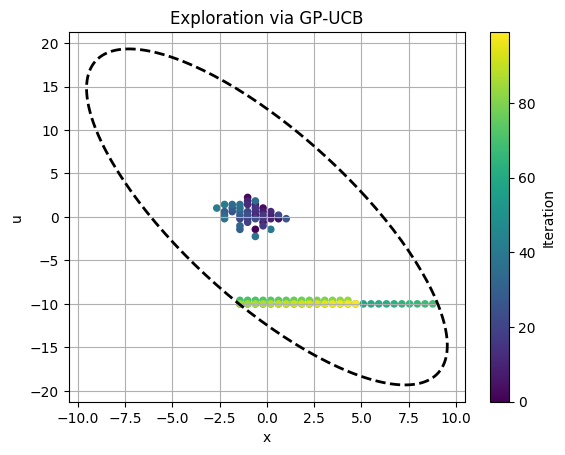

In [29]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.inducing_variables import InducingPoints
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

acq_thresh = 1.5  # adjust to your needs

x_current = np.array([-1,1.9])
x_measured, u_applied, u_LQR, u_OPT, traj_lin, traj_true, s_temp = simulate_to_target_continuous(x_current, state_max, K_c, Ad, Bd, f0, P_c, 1, x0u0, 1, steps=300)
###############################################################################
# 1. Gather Data
###############################################################################
# Suppose you have a rollout: (traj_lin, traj_true)
# We'll define X_data (states) and Y_data (residuals = true - linear).
N = len(traj_lin) - 1
D = 2  # dimension of state

X_data = np.array(traj_lin)[:-1]    # shape (N,2)
Y_temp = (np.array(traj_true) - np.array(traj_lin))[1:, 1]  # shape (N,)
Y_data = Y_temp[:, None]           # shape (N,1)

print("X_data shape =", X_data.shape)
print("Y_data shape =", Y_data.shape)

# Problem data (must be defined by you):
# state_max, K_c, Ad, Bd, f0, P_c, x0u0

# ------------------------------------------------------------------------
# 1) Build & initially train your sparse GP (SGPR) on some seed data:
# ------------------------------------------------------------------------
# Suppose you have initial X_init (N0×2) and Y_init (N0×1).
# X_init, Y_init = ...

M = 30  # # inducing points
kmeans = KMeans(n_clusters=M, random_state=0).fit(X_data)
Z_init = kmeans.cluster_centers_

kernel = gpflow.kernels.SquaredExponential()
model = gpflow.models.SGPR(data=(X_data, Y_data), kernel=kernel,
                           inducing_variable=InducingPoints(Z_init))
model.likelihood.variance.assign(1e-2)
model.likelihood.variance.trainable = True

opt = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        loss = model.training_loss()
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# Initial training
for _ in range(500):
    optimization_step()

X_old, Y_old = model.data

# ------------------------------------------------------------------------
# 2) Define UCB acquisition-based sampler
# ------------------------------------------------------------------------
def choose_next_point_ucb(model, P_c, X_old, x_bounds, u_bounds,
                          grid_size=(40,40), beta=2.0):
    # create grid
    xs = np.linspace(x_bounds[0], x_bounds[1], grid_size[0])
    us = np.linspace(u_bounds[0], u_bounds[1], grid_size[1])
    XX, UU = np.meshgrid(xs, us, indexing='xy')
    candidates = np.vstack([XX.ravel(), UU.ravel()]).T  # (M,2)

    # ellipsoid mask
    mask = np.einsum('ij,jk,ik->i', candidates, P_c, candidates) <= 1
    candidates = candidates[mask]

    # remove old points
    if X_old.shape[0] > 0:
        old_set = set(map(tuple, np.round(X_old, 6)))
        candidates = np.array([p for p in candidates
                               if tuple(np.round(p,6)) not in old_set])
        if candidates.shape[0] == 0:
            raise RuntimeError("No new candidates!")

    # batch GP predict
    mu_tf, sigma_tf = model.predict_f(candidates)
    mu = mu_tf.numpy().ravel()
    sigma = sigma_tf.numpy().ravel()

    # UCB acquisition
    acq = mu + beta * sigma
    idx = np.argmax(acq)
    return tuple(candidates[idx])

def choose_below_threshold(model, P_c, X_old, x_bounds, u_bounds,
                           grid_size=(40,40), beta=2.0, acq_threshold=0.5):
    """
    Pick a new (x,u) inside the ellipsoid x^T P_c x <= 1 whose
    UCB acquisition a = mu + beta*sigma is <= acq_threshold.
    Among those, return the one with largest sigma (most uncertain).
    If none exist, fall back to the standard UCB argmax.
    """
    # 1) build grid
    xs = np.linspace(x_bounds[0], x_bounds[1], grid_size[0])
    us = np.linspace(u_bounds[0], u_bounds[1], grid_size[1])
    XX, UU = np.meshgrid(xs, us, indexing='xy')
    cand = np.vstack([XX.ravel(), UU.ravel()]).T  # (M,2)

    # 2) filter ellipsoid
    mask = np.einsum('ij,jk,ik->i', cand, P_c, cand) <= 1
    cand = cand[mask]

    # 3) remove already seen
    if X_old.shape[0] > 0:
        old_set = set(map(tuple, np.round(X_old,6)))
        cand = np.array([p for p in cand if tuple(np.round(p,6)) not in old_set])
        if cand.size == 0:
            raise RuntimeError("No new candidates!")

    # 4) batch GP predict
    mu_tf, sigma_tf = model.predict_f(cand)
    mu    = mu_tf.numpy().ravel()
    sigma = sigma_tf.numpy().ravel()

    # 5) compute acquisition
    acq = mu + beta * sigma

    # 6) find candidates below threshold
    below = np.where(acq <= acq_threshold)[0]
    if below.size > 0:
        # pick the one with largest sigma among the "below" set
        idx = below[np.argmax(sigma[below])]
    else:
        # fallback: pick standard UCB argmax
        idx = np.argmax(acq)

    return tuple(cand[idx])


# ------------------------------------------------------------------------
# 3) Main exploration loop
# ------------------------------------------------------------------------
iteration = 100
x_bounds = (-10, 10)
u_bounds = (-10, 10)

# hyperparams for online GP updates
MAX_DATASET_SIZE = 2000
INDUCING_REFRESH_EVERY = 20
UPDATE_EVERY = 5
UPDATE_STEPS = 100

x_safe = []
u_safe = []

for n in range(iteration):
    # (a) pick next init_state via UCB
    # init_state = choose_next_point_ucb(model, P_c, X_old,
    #                                    x_bounds, u_bounds,
    #                                    grid_size=(50,50), beta=2.5)
    init_state = choose_below_threshold(
        model, P_c, X_old,
        x_bounds, u_bounds,
        grid_size=(50,50),
        beta=2.5,
        acq_threshold=acq_thresh
    )
    init_state = np.array(init_state)

    # (b) simulate
    x_meas, u_app, u_LQR, u_OPT, traj_lin, traj_true,traj_gp, s_temp = \
        simulate_to_target_continuous_gp(
            init_state, state_max, K_c, Ad, Bd,
            f0, P_c, model, x0u0, 1, steps=50
        )

    # (c) gather new training data
    X_new = np.array(traj_lin)[:-1]    # shape (N,2)
    Y_temp = (np.array(traj_true) - np.array(traj_lin))[1:, 1]  # shape (N,)
    Y_new = Y_temp[:, None]

    # (d) update dataset
    X_old = np.concatenate([X_old, X_new], axis=0)
    Y_old = np.concatenate([Y_old, Y_new], axis=0)
    # limit size
    if X_old.shape[0] > MAX_DATASET_SIZE:
        X_old = X_old[-MAX_DATASET_SIZE:]
        Y_old = Y_old[-MAX_DATASET_SIZE:]
    model.data = (X_old, Y_old)

    # (e) refresh inducing points occasionally
    if n % INDUCING_REFRESH_EVERY == 0:
        kmeans = KMeans(n_clusters=M, random_state=0).fit(X_old)
        model.inducing_variable = InducingPoints(kmeans.cluster_centers_)

    # (f) retrain GP occasionally
    if n % UPDATE_EVERY == 0:
        for _ in range(UPDATE_STEPS):
            optimization_step()

    # (g) record for final plot
    x_safe.append(init_state[0])
    u_safe.append(init_state[1])

# ------------------------------------------------------------------------
# 4) Final plot of all explored points
# ------------------------------------------------------------------------
x_safe = np.array(x_safe)
u_safe = np.array(u_safe)

# ellipse boundary
eigvals, eigvecs = np.linalg.eig(P_c)
a = 1/np.sqrt(eigvals[0])
b = 1/np.sqrt(eigvals[1])
theta = np.linspace(0,2*np.pi,200)
ellipse = np.vstack([a*np.cos(theta), b*np.sin(theta)])
ellipse = eigvecs @ ellipse

plt.figure()
plt.scatter(x_safe, u_safe, c=np.arange(len(x_safe)), cmap='viridis', s=20)
plt.plot(ellipse[0], ellipse[1], 'k--', lw=2)
plt.xlabel('x'); plt.ylabel('u')
plt.title('Exploration via GP‑UCB')
plt.colorbar(label='Iteration')
plt.grid(True)
plt.show()

In [1]:
# ------------------------------------------------------------------------
# 4) Final plot of all explored points
# ------------------------------------------------------------------------
x_safe = np.array(x_safe)
u_safe = np.array(u_safe)

# ellipse boundary
eigvals, eigvecs = np.linalg.eig(P_c)
a = 1/np.sqrt(eigvals[0])
b = 1/np.sqrt(eigvals[1])
theta = np.linspace(0,2*np.pi,200)
ellipse = np.vstack([a*np.cos(theta), b*np.sin(theta)])
ellipse = eigvecs @ ellipse

plt.figure()
plt.scatter(x_safe, u_safe, c=np.arange(len(x_safe)), cmap='viridis', s=20)
plt.plot(ellipse[0], ellipse[1], 'k--', lw=2)
plt.xlabel('x'); plt.ylabel('u')
plt.title('Exploration via GP‑UCB')
plt.colorbar(label='Iteration')
plt.grid(True)
plt.show()

NameError: name 'np' is not defined

x_lin [-0.01188084 -0.00514589] x_nonlin [-0.01188084 -0.00514589]
u_lin [0.01520381] u_nonlin 0.015203810682483122
x_lin [-0.01239543 -0.00259633] x_nonlin [-0.01239543 -0.00259369]
u_lin [0.01407202] u_nonlin 0.014070308504248657
x_lin [-0.01265507 -0.00066987] x_nonlin [-0.0126548  -0.00066725]
u_lin [0.01308763] u_nonlin 0.01308567545791318
x_lin [-0.01272205  0.00077287] x_nonlin [-0.01272153  0.00077482]
u_lin [0.01222297] u_nonlin 0.01222118713212151
x_lin [-0.01264477  0.00184059] x_nonlin [-0.01264404  0.00184203]
u_lin [0.0114562] u_nonlin 0.011454549694577074
x_lin [-0.01246071  0.0026181 ] x_nonlin [-0.01245984  0.00261942]
u_lin [0.01077007] u_nonlin 0.01076834724128135
x_lin [-0.0121989   0.00317148] x_nonlin [-0.0121979   0.00317306]
u_lin [0.01015091] u_nonlin 0.010148893499750703
x_lin [-0.01188175  0.00355228] x_nonlin [-0.01188059  0.00355434]
u_lin [0.00958786] u_nonlin 0.009585372639253636
x_lin [-0.01152652  0.00380061] x_nonlin [-0.01152516  0.00380327]
u_lin [0.

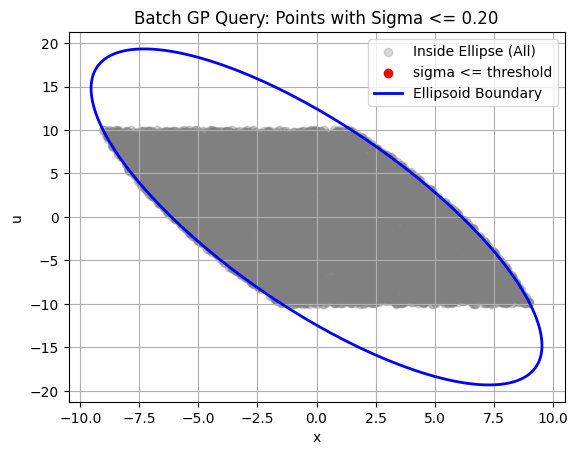

ValueError: attempt to get argmax of an empty sequence

In [26]:

# ------------------------------------------------------------
# Assumptions:
#   - 'model' is a gpflow.models.SGPR or gpflow.models.SVGP
#   - 'optimization_step' is a @tf.function that does one step of Adam on model
#   - 'simulate_to_target_continuous_gp' is your function from before
#   - 'lyapunov_hs' is your function from before
#   - 'state_max', 'K_c', 'Ad', 'Bd', 'f0', 'P_c', 'x0u0' are defined above
# ------------------------------------------------------------



# You might want these as hyperparameters up top:
MAX_DATASET_SIZE = 4000     # Keep at most 2000 data points in the GP
M = 50                      # Number of inducing points
UPDATE_GAP = 5              # Retrain GP only every 5 main iterations
INDUCING_REFRESH_GAP = 10   # Refresh inducing points with k-means every 10 main iterations
ADAM_STEPS = 100            # How many steps of Adam to do when we do train
learning_rate = 0.01

# If you haven't defined your Adam optimizer:
opt = tf.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        loss_value = model.training_loss()
    grads = tape.gradient(loss_value, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

# ---------------------------
# Main loop
# ---------------------------
iteration = 400
x_safe_x = []  # to store x_new from each iteration
x_safe_u = []  # to store u_new from each iteration

for n in range(iteration):
    # ---------------------------
    # Phase logic
    # ---------------------------
    phase = n // 100  # integer division: 0 for first 100, 1 for next 100, etc.

    if phase == 0:
        # "Always pick the point where x_new is maximum"
        idx_xmax = np.argmax(x_new)
        init_state = (x_new[idx_xmax], u_new[idx_xmax])
    elif phase == 1:
        # "Always pick the point where u_new is minimum"
        idx_umin = np.argmin(u_new)
        init_state = (x_new[idx_umin], u_new[idx_umin])
    elif phase == 2:
        # "Always pick the point where x_new is minimum"
        idx_xmin = np.argmin(x_new)
        init_state = (x_new[idx_xmin], u_new[idx_xmin])
    else:
        # "Always pick the point where u_new is maximum"
        idx_umax = np.argmax(u_new)
        init_state = (x_new[idx_umax], u_new[idx_umax])

    init_state_array = np.array(init_state)

    # ---------------------------
    # Simulate from init_state
    # ---------------------------
    x_measured, u_applied, u_LQR, u_OPT, traj_lin, traj_true, s_temp = \
        simulate_to_target_continuous(
            init_state_array,
            state_max,
            K_c,
            Ad, Bd,
            f0,
            P_c,
            model,
            x0u0,
            1,
            steps=50
        )

    # Gather new data
    N_samples = len(traj_lin) - 1
    X_data_new = np.array(traj_lin[:-1])  # shape (N_samples, 2)
    Y_data_new = np.array(traj_true)[1:] - np.array(traj_lin)[1:]  # shape (N_samples, 2) -> residual
    # We only keep the second component for Y (based on your original code)
    Y_data_new = Y_data_new[:, 1][:, None]  # shape (N_samples, 1)

    # (1) Retrieve the current training data from the model
    X_old, Y_old = model.data

    # (2) Concatenate old + new
    X_new = np.concatenate([X_old, X_data_new], axis=0)
    Y_new = np.concatenate([Y_old, Y_data_new], axis=0)

    print(f"Iteration {n}, updated number of samples: {X_new.shape[0]}")

    # (2a) LIMIT the maximum dataset size
    if X_new.shape[0] > MAX_DATASET_SIZE:
        # Keep only the most recent data
        X_new = X_new[-MAX_DATASET_SIZE:]
        Y_new = Y_new[-MAX_DATASET_SIZE:]

    # (3) Assign data back to the model
    model.data = (X_new, Y_new)

    # (3a) Every INDUCING_REFRESH_GAP steps, do a K-means to refresh Z
    if (n % INDUCING_REFRESH_GAP == 0) and (X_new.shape[0] >= M):
        print(f"Refreshing {M} inducing points via k-means at iteration {n}...")
        kmeans = KMeans(n_clusters=M, random_state=42)
        kmeans.fit(X_new)
        Z_new = kmeans.cluster_centers_
        model.inducing_variable = InducingPoints(Z_new)

    # (4) Retrain the GP only every UPDATE_GAP steps
    if n % UPDATE_GAP == 0:
        print(f"Re-training the GP at iteration {n} (Adam steps={ADAM_STEPS})...")
        for step in range(ADAM_STEPS):
            current_loss = optimization_step()
            if step % 50 == 0:
                print(f"(Update) Step {step}, loss = {current_loss.numpy():.4f}")

        # Inspect final training loss
        final_loss = model.training_loss().numpy()
        print(f"=== GP Re-trained at iteration {n} ===")
        print(f"Final training loss: {final_loss:.4f}")

        # If you want to see kernel hyperparams:
        if hasattr(model.kernel, "lengthscales"):
            print(f"Kernel lengthscales: {model.kernel.lengthscales.numpy()}")
        if hasattr(model.kernel, "variance"):
            print(f"Kernel variance:     {model.kernel.variance.numpy()}")

    # ----------------------------------------------------
    # Next: sample 1000 points, filter by ellipse + lyapunov_hs
    # ----------------------------------------------------
    np.random.seed(26)
    N = 20000 # Number of points
    x_values = np.random.uniform(-10, 10, N)  # 100 random x values in [-10, 10]
    u_values = np.random.uniform(-10, 10, N)  # 100 random u values in [-10, 10]

    # Combine them in a list (or however you need)
    x_current = np.array([x_values, u_values])

    threshold_mean = 0.4
    threshold_sigma = 0.2

    # Suppose x_current has shape (2, N).
    #   x_current[0, i] = x-value
    #   x_current[1, i] = u-value

    # 1) Gather indices of points inside the ellipse x^T P_c x <= 1
    inside_indices = []
    for i in range(N):
        x_vec = x_current[:, i]  # shape (2,)
        if (x_vec.T @ P_c @ x_vec) <= 1:
            inside_indices.append(i)

    inside_indices = np.array(inside_indices, dtype=int)

    # 2) Extract all those points as a (k, 2) array for GPflow
    X_inside = x_current[:, inside_indices].T  # shape: (k, 2), where k <= N

    # 3) Call the GP ONCE for all points
    gp_mean_tf, gp_sigma_tf = model.predict_f(X_inside)
    gp_mean = gp_mean_tf.numpy().ravel()   # shape (k,)
    gp_sigma = gp_sigma_tf.numpy().ravel() # shape (k,)

    # 4) Based on sigma <= threshold, define s-values
    #    We'll say s=0 if sigma <= threshold, else s=1 (like your example).
    #    This is a vectorized comparison:
    s_values_mean = np.where(gp_mean <= threshold_mean, 0.0, 1.0)
    s_values_sigma = np.where(gp_sigma <= threshold_sigma, 0.0, 1.0)

    # 5) "valid_indices": those with s=0
    valid_indices = np.where(
    (s_values_mean == 0.0) & (s_values_sigma == 0.0)
    )[0]

    # 6) The final x_new, u_new are the "inside" points that also have s=0
    x_new = X_inside[valid_indices, 0]  # shape (k_valid,)
    u_new = X_inside[valid_indices, 1]  # shape (k_valid,)

    # Save for final plotting
    x_safe_x.append(x_new)
    x_safe_u.append(u_new)

    if (n % INDUCING_REFRESH_GAP == 0):
        # 7) Plot the results
        #    We'll also plot the ellipse boundary for reference
        eigvals, eigvecs = np.linalg.eig(P_c)
        a = 1/np.sqrt(eigvals[0])
        b = 1/np.sqrt(eigvals[1])
        theta = np.linspace(0, 2*np.pi, 200)
        ellipse_boundary = np.array([a*np.cos(theta), b*np.sin(theta)])
        ellipse_rotated = eigvecs @ ellipse_boundary

        plt.figure()
        # Plot all points inside the ellipse (optional):
        all_x = X_inside[:, 0]
        all_u = X_inside[:, 1]
        plt.scatter(all_x, all_u, color='gray', alpha=0.3, label='Inside Ellipse (All)')

        # Plot the final "valid" set in red
        plt.scatter(x_new, u_new, color='red', label='sigma <= threshold')

        plt.plot(ellipse_rotated[0,:], ellipse_rotated[1,:], 'b-', lw=2, label='Ellipsoid Boundary')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.title('Batch GP Query: Points with Sigma <= {:.2f}'.format(threshold_sigma))
        plt.legend()
        plt.grid(True)
        plt.show()

# -----------------------------------------------------------
# After the loop, plot all safe points
x_safe_x_all = np.concatenate(x_safe_x)
x_safe_u_all = np.concatenate(x_safe_u)

plt.figure()
plt.scatter(x_safe_x_all, x_safe_u_all, color='red', label='All s < 1e-6')
plt.plot(ellipse_rotated[0,:], ellipse_rotated[1,:], 'b-', lw=2, label='CIS Riccati')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Final HS SET')
plt.legend()
plt.grid(True)
plt.show()